In [58]:
# Initialize the environment
# Update: 2018-11-27

import numpy as np
import platform
import tempfile
import os
import math
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color
from scipy.fftpack import dct
from scipy.stats import binom
from scipy.fft import dct
import cv2
from PIL import Image

[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 1.]]


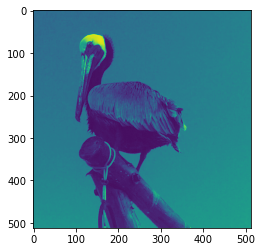

In [59]:
pelican=io.imread('pelican99.jpg')
lena=io.imread('lena5.jpg')
pelican = color.rgb2ycbcr(pelican)
lena = color.rgb2ycbcr(lena)
roma=io.imread('roma.png')
roma = color.rgb2ycbcr(cv2.cvtColor(roma, cv2.COLOR_BGR2RGB))

harry=io.imread('harry20.jpg')
harry= color.rgb2ycbcr(harry)

votes = np.zeros((2,3)) # Table des votes
print(votes)
votes[1,2] = 1
print(votes)

plt.imshow(pelican[:,:,0])
plt.show()

In [60]:
def jpgQF(image, sortie, QF=85):
    img = Image.open(image)
    img.save(sortie, quality=QF)

image = "harry.jpg"
sortie = "harry50.jpg"
QF = 50 # Quality Factor
jpgQF(image, sortie, QF)


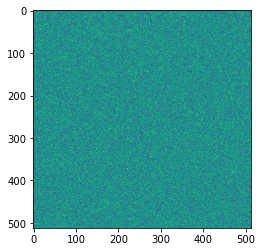

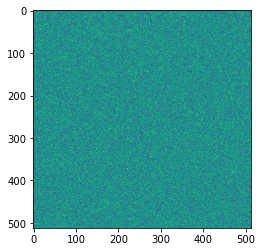

In [61]:
# Générer un bruit gaussien avec une moyenne de 128 et un écart-type de 50
mean = 128
std_dev = 50
noise = np.random.normal(mean, std_dev, (512, 512)).astype(np.uint8)

# Créer une image à partir du bruit gaussien
img = Image.fromarray(noise, mode='L')  # 'L' pour une image en niveaux de gris

# Enregistrer l'image en format JPEG
img.save('gaussian_noise.jpg', 'JPEG')

gaussian_noise = io.imread('gaussian_noise.jpg')
plt.imshow(gaussian_noise)
plt.show()
gaussian_noise = color.rgb2ycbcr(cv2.cvtColor(gaussian_noise, cv2.COLOR_BGR2RGB))
plt.imshow(gaussian_noise[:,:,0])
plt.show()

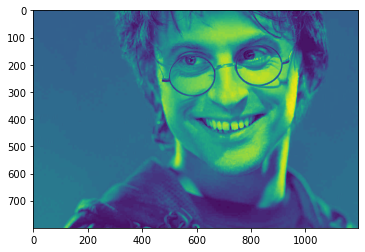

In [62]:
def im_luminance(im):
    if len(im.shape) == 3:
        R, G, B = im[:,:,0], im[:,:,1], im[:,:,2]
        luminance = 0.299*R + 0.587*G + 0.114*B
    else:
        luminance = im
    return luminance

plt.imshow(harry[:,:,0])
plt.show()


In [63]:
def BinTail(n,k,p):
    return 1-binom.cdf(k-1,n,p)

In [64]:
def NFA(nvotes,X,Y) : # on lui donne en entrée le nombre de votes pour la grille sur laquelle on veut calculer le NFA, et la taille de l'image
    p = 1/64
    n=(X*Y)/64
    nvotes2 = nvotes/64
    # Remarque : on pourrait calculer nvotes directement à l'intérieur de cette fonction, mais il faudrait lui donner la carte des votes.
    return ((X*Y*64)**2)*BinTail(n,nvotes2,p)


In [65]:

def voteMAP(image): # image en luminance
    shape = image.shape
    X = shape[0]
    Y = shape[1]
    votes = np.zeros((X,Y)) # Table des votes
    zeros = np.zeros((X,Y)) # Table des zeros
    # DCT par blocs de 8x8 pixels
    counter = 0
    for x in range(X - 7):
        for y in range(Y - 7):
            counter += 1
            #print(f"Bloc n°{counter}")
            z = 0 # Nombre de zeros dans le bloc
            bloc = image[x:x+8,y:y+8,0]
            cx = True
            cy = True
            for xx in range(8):
                for yy in range(8):
                    #print(f"bloc[{xx},{yy}] = {bloc[xx,yy]}")
                    if bloc[xx,yy] != bloc[xx,0]: #On verifie que le bloc n'est pas constant selon x
                        cx = False
                        break
                    if bloc[xx,yy] != bloc[0,yy]: #idem pour y
                        cy = False
                        break
                if not cx or not cy:
                    break
            #print(f"cx = {cx}, cy = {cy}")

            dctblock = dct(dct(bloc.T, norm='ortho').T, norm='ortho') # DCT du bloc
            for xx in range(8):
                for yy in range(8):
                    if abs(dctblock[xx,yy]) < 0.5:
                        z += 1 # On compte les zeros
            
            for xx in range(x, x + 8): # On vote pour le bloc
                for yy in range(y, y + 8):
                    if z > 0 and z > votes[xx,yy]:
                        if cx or cy:
                            votes[xx,yy] = -1
                        else:
                            zeros[xx,yy] = z
                            votes[xx,yy] = ((x%8 + y%8 * 8)-1) # On vote pour la meilleure grille
                        
    # On elimine les bordures de l'image
    for xx in range(X):
        for yy in range(7):
            votes[xx,yy] = -1
        for yy in range(Y - 7, Y):
            votes[xx,yy] = -1
    for yy in range(Y):
        for xx in range(7):
            votes[xx,yy] = -1
        for xx in range(X - 7, X):
            votes[xx,yy] = -1
    
    print(f"Nombre de blocs : {counter}")
    print("voteMAP terminé")
    
    return votes

In [66]:
def voteMAPfast(image): 
    shape = image.shape
    X, Y = shape[:2]
    votes = np.zeros((X, Y))
    zeros = np.zeros((X, Y))
    
    for x in range(X - 7):
        for y in range(Y - 7):
            bloc = image[x:x+8, y:y+8, 0]
            cx = np.all(bloc[:, 0] == bloc[:, 0][0]) # Check constantité selon x
            cy = np.all(bloc[0, :] == bloc[0, :][0]) # Check constantité selon y
            
            if not cx or not cy:
                dctblock = dct(dct(bloc.T, norm='ortho').T, norm='ortho')
                z = np.sum(np.abs(dctblock) < 0.5)  # Compter les zéros
                
                for xx in range(x, x + 8):
                    for yy in range(y, y + 8):
                        if z > 0 and z > votes[xx, yy]:
                            if cx or cy:
                                votes[xx, yy] = -1
                            else:
                                zeros[xx, yy] = z
                                votes[xx, yy] = (x % 8 + y % 8 * 8)
    
    # Éliminer les bordures de l'image
    votes[:7, :] = -1
    votes[-7:, :] = -1
    votes[:, :7] = -1
    votes[:, -7:] = -1
    
    print("voteMAPfast terminé")
    
    return votes


In [67]:
def detectgrid (im) : # le but de la fonction est de detecter la grille la plus presente dans l'image et de la renvoyer (on renvoye aussi maxvote juste comme indicateur)
    shape = im.shape
    X = shape[0]
    Y = shape[1]  
    votes = voteMAP(im)
    gridvotes = np.zeros((8,8))
    maxvote = 0
    mostvotedgrid = (0,0)
    for x in range(X) :
        for y in range(Y) :
            if isinstance(int(votes[x,y]),int) :
                #print("vote : ",int(votes[x,y]))
                if int(votes[x,y]) != -1 :
                    gridvotes[np.unravel_index(int(votes[x,y]),(8,8))]+=1
                    if gridvotes[np.unravel_index(int(votes[x,y]),(8,8))]> maxvote :
                        maxvote = gridvotes[np.unravel_index(int(votes[x,y]),(8,8))]
                        mostvotedgrid = np.unravel_index(int(votes[x,y]),(8,8))
    NFAv = NFA(maxvote,X,Y)
    if NFAv<1 :
        print("La grille la plus presente dans l'image est la grille de coordonnees : ",mostvotedgrid," avec ",maxvote," votes")
        print("Le NFA de cette grille est : ",NFAv)
        return mostvotedgrid, maxvote  # on renvoie la grille la plus presente dans l'image sous forme de tuple (x,y) entre 0 et 7
    else :
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0,0),0
    

In [68]:
def detectgridfast(im):
    plt.imshow(im[:,:,0])
    plt.show()
    shape = im.shape[:2]
    X, Y = shape
    votes = voteMAPfast(im)
    gridvotes = np.zeros((8, 8))

    valid_votes = votes != -1
    valid_indices = np.argwhere(valid_votes)

    for x, y in valid_indices:
        grid_idx = np.unravel_index(int(votes[x, y]), (8, 8))
        gridvotes[grid_idx] += 1

    mostvotedgrid = np.unravel_index(np.argmax(gridvotes), (8, 8))
    maxvote = gridvotes[mostvotedgrid]

    NFAv = NFA(maxvote, X, Y)

    if NFAv < 1:
        print("La grille la plus présente dans l'image est la grille de coordonnées : ",
              mostvotedgrid, " avec ", maxvote, " votes")
        print("Le NFA de cette grille est : ", NFAv)
        return mostvotedgrid, maxvote  
    else:
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0, 0), 0


In [69]:
def votesforeachpixel(im) :
    shape = im.shape
    X = shape[0]
    Y = shape[1]  
    zeros = np.zeros((X,Y))
    votes = np.zeros((X,Y))
    for x in range(X-7) :
        for y in range(Y-7) :
            block = im[x:x+8,y:y+8,0]
            constantx = False
            constanty = False
            #on regarde si le block est constant selon x ou y
            for xx in range(8) :
                for yy in range(8) :
                    if block[xx,yy] == block [xx,0] :
                        constanty = True

                    if block[xx,yy] == block [0,yy] :
                        constantx = True

            dctblock = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            nbzeros = 0

            for i in range(8) :
                for j in range(8) :
                    if abs(dctblock[i,j])<0.5 :
                        nbzeros+=1
            for xx in range(8) :
                for yy in range(8) :
                    if nbzeros>zeros[x+xx,y+yy] :
                        zeros[x+xx,y+yy] = nbzeros
                        if not (constantx or constanty) :
                            votes[x+xx,y+yy]= (x%8,y%8)
    return votes # on renvoie un tableau de taille X*Y*2 avec en chaque point le vote pour la grille la plus presente. 
# Ce vote correspond a un tuple (x,y) entre 0 et 7

In [70]:
def forgeries() :
    return 0

In [71]:
def zero(input, image, luminance, luminance_jpeg, votes, votes_jpeg, lnfa_grids, foreign_regions, foreign_regions_n, missing_regions, missing_regions_n, mask_f, mask_f_reg, mask_m, mask_m_reg, X, Y, C, C_jpeg):
    main_grid = -1
    im = im_luminance(image)
    main_grid = detectgrid(im)
    foreign_regions_n[0] = forgeries(votes, mask_f, mask_f_reg, foreign_regions, X, Y, main_grid, 63)
    if main_grid > -1 and image is not None:
        im_luminance(image, luminance_jpeg, X, Y, C_jpeg)
        voteMAP(luminance_jpeg, votes_jpeg, X, Y)
        for x in range(X):
            for y in range(Y):
                if votes[x+y*X] == main_grid:
                    votes_jpeg[x+y*X] = -1
        missing_regions_n[0] = forgeries(votes_jpeg, mask_m, mask_m_reg, missing_regions, X, Y, -1, 0)

    return main_grid


In [72]:
def imcolor(image):
    X = image.shape[0]
    Y = image.shape[1]
    color_map = np.random.randint(0, 255, (8, 8, 3), dtype=int)
    vote_map = voteMAPfast(image)
    new_image = np.zeros((X, Y, 3), dtype=int)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            vote = vote_map[x,y]
            if vote == -1:
                new_image[x,y] = [0, 0, 0]  # les bords et les pixels à -1 sont mis en noir
            else:
                colorpRED = color_map[np.unravel_index(int(vote), (8, 8))][0]
                colorpGREEN = color_map[np.unravel_index(int(vote), (8, 8))][1]
                colorpBLUE = color_map[np.unravel_index(int(vote), (8, 8))][2]
                new_image[x,y,0] = colorpRED
                new_image[x,y,1] = colorpGREEN
                new_image[x,y,2] = colorpBLUE
                
    return new_image

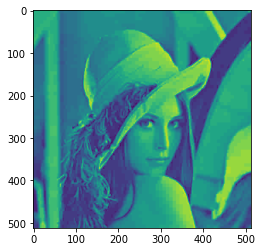

voteMAPfast terminé
La grille la plus présente dans l'image est la grille de coordonnées :  (7, 7)  avec  12735.0  votes
Le NFA de cette grille est :  0.0
((7, 7), 12735.0)
Nombre de blocs : 255025
voteMAP terminé
Il n'y a pas de grille dans l'image car NFA > 1
((0, 0), 0)


"print(detectgridfast(pelican))\npelican50 = io.imread('pelican50.jpg')\npelican50 = color.rgb2ycbcr(pelican50)\nprint(detectgridfast(pelican50))\npelican20 = io.imread('pelican20.jpg')\npelican20 = color.rgb2ycbcr(pelican20)\nprint(detectgridfast(pelican20))"

In [73]:
print(detectgridfast(lena))
print(detectgrid(lena))
'''print(detectgridfast(pelican))
pelican50 = io.imread('pelican50.jpg')
pelican50 = color.rgb2ycbcr(pelican50)
print(detectgridfast(pelican50))
pelican20 = io.imread('pelican20.jpg')
pelican20 = color.rgb2ycbcr(pelican20)
print(detectgridfast(pelican20))'''

voteMAPfast terminé


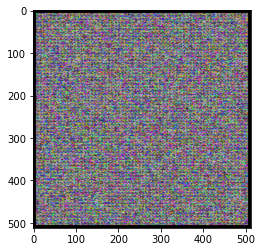

In [76]:
pelican50 = io.imread('pelican20.jpg')
pelican50 = color.rgb2ycbcr(pelican50)
plt.imshow(imcolor(gaussian_noise))
plt.show()

In [75]:
'''harry=io.imread('harry.jpg')
harry= color.rgb2ycbcr(harry)

harry75=io.imread('harry75.jpg')
harry75= color.rgb2ycbcr(harry75)

harry50=io.imread('harry50.jpg')
harry50= color.rgb2ycbcr(harry50)

harry30=io.imread('harry30.jpg')
harry30= color.rgb2ycbcr(harry30)

harry20=io.imread('harry20.jpg')
harry20= color.rgb2ycbcr(harry20)

harry10=io.imread('harry10.jpg')
harry10= color.rgb2ycbcr(harry10)

print(detectgridfast(harry))
print(detectgridfast(harry75))
print(detectgridfast(harry50))
print(detectgridfast(harry30))
print(detectgridfast(harry20))
print(detectgridfast(harry10))

plt.imshow(imcolor(harry))
plt.show()

plt.imshow(imcolor(harry75))
plt.show()

plt.imshow(imcolor(harry50))
plt.show()

plt.imshow(imcolor(harry30))
plt.show()

plt.imshow(imcolor(harry20))
plt.show()

plt.imshow(imcolor(harry10))
plt.show()'''

"harry=io.imread('harry.jpg')\nharry= color.rgb2ycbcr(harry)\n\nharry75=io.imread('harry75.jpg')\nharry75= color.rgb2ycbcr(harry75)\n\nharry50=io.imread('harry50.jpg')\nharry50= color.rgb2ycbcr(harry50)\n\nharry30=io.imread('harry30.jpg')\nharry30= color.rgb2ycbcr(harry30)\n\nharry20=io.imread('harry20.jpg')\nharry20= color.rgb2ycbcr(harry20)\n\nharry10=io.imread('harry10.jpg')\nharry10= color.rgb2ycbcr(harry10)\n\nprint(detectgridfast(harry))\nprint(detectgridfast(harry75))\nprint(detectgridfast(harry50))\nprint(detectgridfast(harry30))\nprint(detectgridfast(harry20))\nprint(detectgridfast(harry10))\n\nplt.imshow(imcolor(harry))\nplt.show()\n\nplt.imshow(imcolor(harry75))\nplt.show()\n\nplt.imshow(imcolor(harry50))\nplt.show()\n\nplt.imshow(imcolor(harry30))\nplt.show()\n\nplt.imshow(imcolor(harry20))\nplt.show()\n\nplt.imshow(imcolor(harry10))\nplt.show()"